<a href="https://colab.research.google.com/github/woneuy01/NLP_Jon/blob/master/multi_convnet_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-ConvNet Sentiment Classifier

In this notebook, we concatenate the outputs of *multiple, parallel convolutional layers* to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [0]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model # new!
from tensorflow.keras.layers import Input, concatenate # new! 
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

#### Set hyperparameters

In [0]:
# output directory name:
output_dir = 'model_output/multiconv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# convolutional layer architecture:
n_conv_1 = n_conv_2 = n_conv_3 = 256 
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

# dense layer architecture: 
n_dense = 256
dropout = 0.2

#### Load data

In [0]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) 

17465344/17464789 [==============================] - 1s 0us/step


#### Preprocess data

In [0]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [0]:
input_layer = Input(shape=(max_review_length,), 
                    dtype='int16', name='input') 

# embedding: 
embedding_layer = Embedding(n_unique_words, n_dim, 
                            name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, 
                                    name='drop_embed')(embedding_layer)
# 모델이 옆으로 세개가 있는데 k_conv길이를 1,2,3개로 돌림
# three parallel convolutional streams: 
conv_1 = Conv1D(n_conv_1, k_conv_1, 
                activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, 
                activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, 
                activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

# concatenate the activations from the three streams: 
concat = concatenate([maxp_1, maxp_2, maxp_3])

# dense hidden layers: 
dense_layer = Dense(n_dense, 
                    activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
dense_2 = Dense(int(n_dense/4), 
                activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

# sigmoid output layer: 
predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

# create model: 
model = Model(input_layer, predictions)

In [0]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 400, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 398, 256)     49408       drop_embed[0][0]                 
______________________________________________________________________________________________

#### Configure model

In [0]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [0]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [0]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 9s 44ms/step - loss: 0.4893 - accuracy: 0.7330 - val_loss: 0.2940 - val_accuracy: 0.8763
Epoch 2/4
196/196 [==============================] - 8s 42ms/step - loss: 0.2612 - accuracy: 0.8956 - val_loss: 0.2635 - val_accuracy: 0.8900
Epoch 3/4
196/196 [==============================] - 8s 43ms/step - loss: 0.1906 - accuracy: 0.9288 - val_loss: 0.2718 - val_accuracy: 0.8916
Epoch 4/4
196/196 [==============================] - 8s 43ms/step - loss: 0.1463 - accuracy: 0.9480 - val_loss: 0.2705 - val_accuracy: 0.8953


#### Evaluate

In [0]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [0]:
y_hat = model.predict(x_valid)

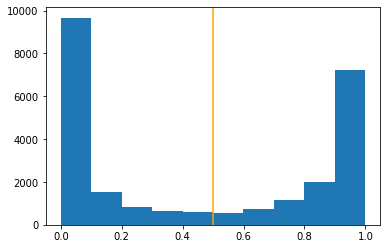

In [0]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [0]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.12'